# Adversarial attack on BN and SBN

In [5]:
%env CUDA_VISIBLE_DEVICES=1
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd
import numpy as np

%matplotlib inline
import sys
sys.path.append('./StochBN/')
from utils import *

%load_ext autoreload
%autoreload 2

max_5_entropy = entropy(np.ones((1, 5)) / 5.)[0]

# from StochBN import models

env: CUDA_VISIBLE_DEVICES=1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## SBN

In [163]:
trainloader, testloader = get_dataloader(data='cifar5', data_root='../data/')
net = load_model('./vgg-exps/cifar5/sbn/bs8/best_model')
# net = load_model('../vgg-exps/cifar5/bn/bs32/best_model')
set_bn_mode(net, 'StochBN')
net.eval();

Files already downloaded and verified
Files already downloaded and verified


In [164]:
def ensemble_adversarial(net, dataloader, eps, ensembles=50):
    loss = nn.CrossEntropyLoss().cuda()
    counter = AccCounter()
    max_ent = 0
    ent = []
    pred_labels = []
    gt_labels = []
    for img, label in testloader:
        adv = fast_adversarial(img, label, net, loss, eps)
        pred = predict_proba_batch(adv, net, ensembles=ensembles)
        ent.append(entropy(pred))
        counter.add(pred, label.numpy())
        pred_labels = pred_labels + pred.argmax(1).tolist()
        gt_labels = gt_labels + label.tolist()

    return counter.acc(), ent, np.array(gt_labels), np.array(pred_labels)

In [3]:
# df = pd.read_csv('results/cifar5/uncertainty/adversarial_attack_sbn.csv')

In [ ]:
from tqdm import tqdm

eps_grid = np.linspace(0, 0.4, 9)
# df = pd.DataFrame(columns=['eps', 'type', 'acc', 'entropy', 'ent_corr', 'ent_incorr'])
bs_grid = [4, 16, 32, 128]
for bs in bs_grid:
    net = load_model('./vgg-exps/vgg11-0.5-uncertainty-out5/bs{}/sample_mean/sample_var/one/after/best_model'.format(bs))
    set_bn_mode(net, 'StochBN')
    net.eval()

    set_MyBN_strategy(net, mean_strategy='sample', var_strategy='sample')
    for eps in eps_grid:
        acc, ent, gt, pred = ensemble_adversarial(net, testloader, eps)
        ent = np.concatenate(ent)
        c = (gt == pred)
        df = df.append(pd.DataFrame([[eps, bs, 'Ensemble', acc, ent, ent[c], ent[~c]]],
                                    columns=['eps', 'bs', 'type', 'acc', 'entropy', 'ent_corr', 'ent_incorr']),
                       ignore_index=True)


    set_MyBN_strategy(net, mean_strategy='running', var_strategy='running')
    for eps in eps_grid:
        acc, ent, gt, pred = ensemble_adversarial(net, testloader, eps)
        ent = np.concatenate(ent)
        c = (gt == pred)
        df = df.append(pd.DataFrame([[eps, bs, 'Eval', acc, ent, ent[c], ent[~c]]],
                                    columns=['eps', 'bs', 'type', 'acc', 'entropy', 'ent_corr', 'ent_incorr']),
                       ignore_index=True)

In [217]:
# df.to_csv('adversarial_attack_sbn')

In [ ]:
plt.figure(figsize=(15, 10))

t = df[df['type'] == 'Ensemble']

plt.subplot(2, 3, 1)
plt.title('Ensemble')
sns.violinplot(data=t['entropy'].values / max_5_entropy)

plt.subplot(2, 3, 2)
plt.title('Ensemble correct')
sns.violinplot(data=t['ent_corr'] / max_5_entropy)

plt.subplot(2, 3, 3)
plt.title('Ensemble incorrect')
sns.violinplot(data=t['ent_incorr'] / max_5_entropy)

t = df[df['type'] == 'Eval']

plt.subplot(2, 3, 4)
plt.title('Eval')
sns.violinplot(data=t['entropy'] / max_5_entropy)

plt.subplot(2, 3, 5)
plt.title('Eval correct')
sns.violinplot(data=t['ent_corr'] / max_5_entropy)

plt.subplot(2, 3, 6)
plt.title('Eval incorrect')
sns.violinplot(data=t['ent_incorr'] / max_5_entropy)

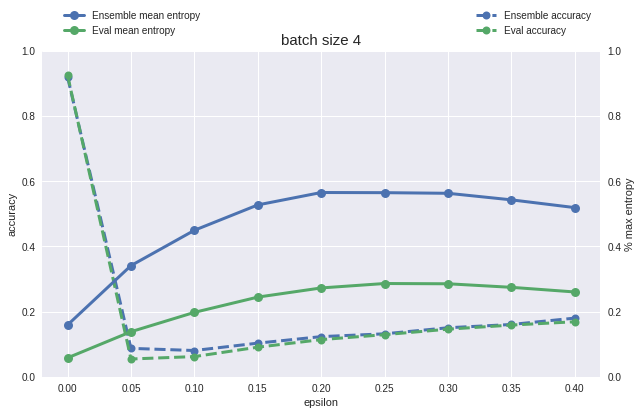

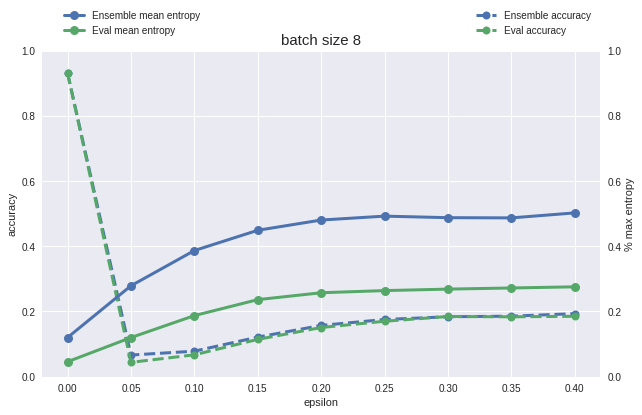

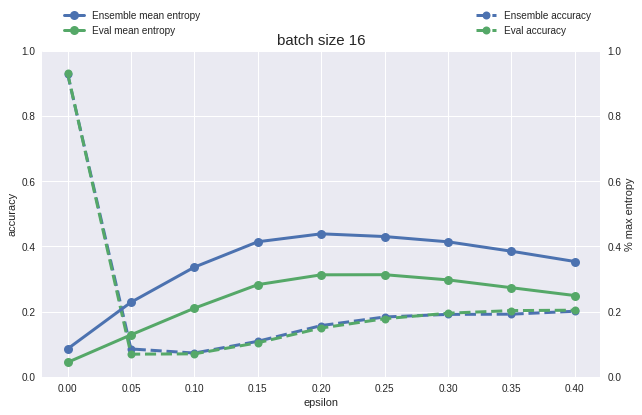

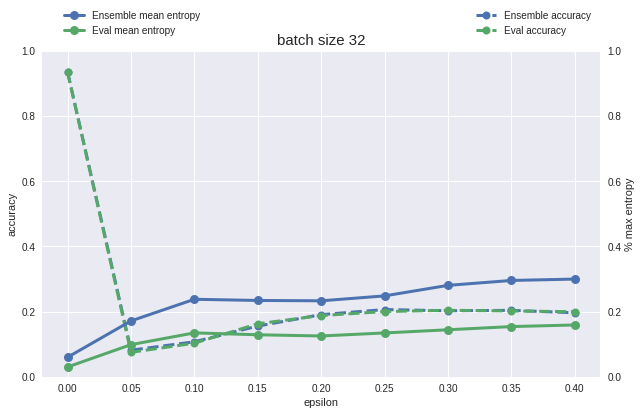

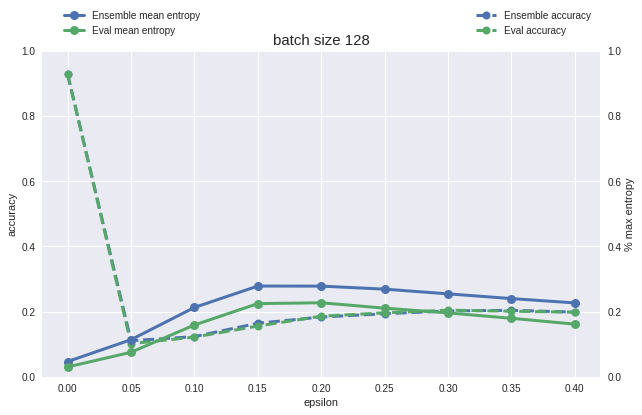

In [231]:

bs_grid = [4, 8, 16, 32, 128]
for bs in bs_grid:
    plt.figure(figsize=(10, 6))
    plt.title('batch size {}'.format(bs), size=15)
    t = df[df['type'] == 'Ensemble']
    t = t[t['bs'] == bs]
    plt.plot(t['eps'], t['acc'], ls='--', lw=3., marker='o', ms=8., label='Ensemble accuracy')
    t = df[df['type'] == 'Eval']
    t = t[t['bs'] == bs]
    plt.plot(t['eps'], t['acc'], ls='--', lw=3., marker='o', ms=8., label='Eval accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epsilon')
    plt.legend(bbox_to_anchor=(1, 1.15))
    plt.yticks(np.linspace(0, 1., 6))


    plt.twinx()

    t = df[df['type'] == 'Ensemble']
    t = t[t['bs'] == bs]
    plt.plot(t['eps'], t['entropy'].apply(np.mean) / max_5_entropy,
             ms=9., lw=3, ls='-', marker='o', label='Ensemble mean entropy')
    # mean = t['entropy'].apply(np.mean) / max_5_entropy
    # err = t['entropy'].apply(np.std) / max_5_entropy
    # plt.errorbar(t['eps'], mean, yerr=[err, err], ls='-', marker='o', label='Ensemble')

    t = df[df['type'] == 'Eval']
    t = t[t['bs'] == bs]
    plt.plot(t['eps'], t['entropy'].apply(np.mean) / max_5_entropy,
             ms=9., lw=3, ls='-',marker='o', label='Eval mean entropy')
    # mean = t['entropy'].apply(np.mean) / max_5_entropy
    # err = t['entropy'].apply(np.std) / max_5_entropy
    # plt.errorbar(t['eps'], mean, yerr=[err, err], ls='-', marker='o', label='Eval')
    plt.ylabel('% max entropy')
    plt.yticks(np.linspace(0, 1., 6))

    plt.legend(bbox_to_anchor=(0.3, 1.15))
    plt.grid()
    plt.show()

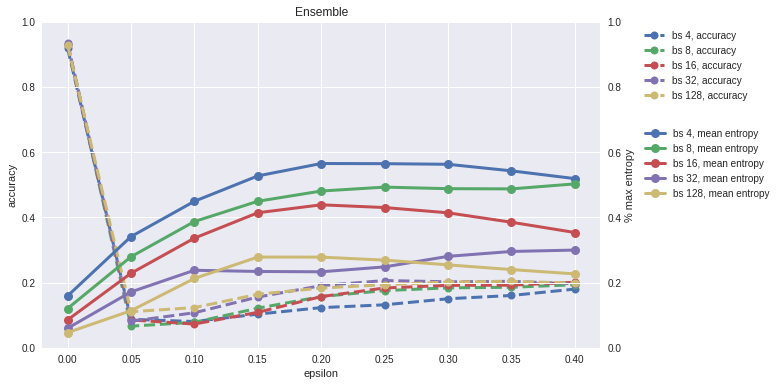

In [216]:
plt.figure(figsize=(10, 6))
max_5_entropy = entropy(np.ones((1, 5)) / 5.)[0]
bs_grid = [4, 8, 16, 32, 128]
plt.title('Ensemble')

for bs in bs_grid:
    t = df[df['type'] == 'Ensemble']
    t = t[t['bs'] == bs]
    plt.plot(t['eps'], t['acc'], ls='--', lw=3., marker='o', ms=8., label='bs {}, accuracy'.format(bs))
    plt.ylabel('accuracy')
    plt.xlabel('epsilon')

plt.legend(bbox_to_anchor=(1.28, 1.))
plt.yticks(np.linspace(0, 1., 6))


plt.twinx()
for bs in bs_grid:
    t = df[df['type'] == 'Ensemble']
    t = t[t['bs'] == bs]
    plt.plot(t['eps'], t['entropy'].apply(np.mean) / max_5_entropy,
             ms=9., lw=3, ls='-', marker='o', label='bs {}, mean entropy'.format(bs))
    plt.ylabel('% max entropy')


plt.legend(bbox_to_anchor=(1.32, 0.7))

plt.yticks(np.linspace(0, 1., 6));
# plt.grid(False)